In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as F
import sys
plt.style.use('ggplot')

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df lecture") \
            .getOrCreate()
sc = spark.sparkContext

# Pull in artist feautures data

    -create spark df as df_artist_features

In [3]:
print(sys.path)

['/home/jovyan/work/Documents/dsi/Capstone1/notebooks', '/tmp/spark-fa99ddef-12ed-41ec-9929-f2f25246c648/userFiles-5d8a0dfa-1afa-47dc-9fec-e7a501a0d673', '/usr/local/spark/python/lib/py4j-0.10.9-src.zip', '/usr/local/spark/python', '/home/jovyan/work/Documents/dsi/Capstone1/notebooks', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/jovyan/.ipython']


In [4]:
dba = pd.read_csv('/home/jovyan/work/Documents/dsi/Capstone1/data/data_by_artist.csv')
dba.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7


In [5]:
df_artist_features = spark.read.csv('/home/jovyan/work/Documents/dsi/Capstone1/data/data_by_artist.csv',header=True).cache()
df_artist_features.printSchema()
print("line count: {}".format(df_artist_features.count()))
df_artist_features.show()

root
 |-- artists: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- count: string (nullable = true)

line count: 32539
+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+----+-----+
|             artists|       acousticness|       danceability|       duration_ms|             energy|    instrument

# Pull in million-playlist data

    -Playlist level data as df_playlistsdf_features

    -Track level data as df_tracks

In [6]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [7]:
million_list = spark.read.json('/home/jovyan/work/Documents/dsi/Capstone1/data/mpd.slice.0-999.json',multiLine=True).cache()

# prints the schema
million_list.printSchema()

# some functions are still valid
print("line count: {}".format(million_list.count()))

# show the table in a oh-so-nice format
million_list.show()

root
 |-- info: struct (nullable = true)
 |    |-- generated_on: string (nullable = true)
 |    |-- slice: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- playlists: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- collaborative: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- modified_at: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- num_albums: long (nullable = true)
 |    |    |-- num_artists: long (nullable = true)
 |    |    |-- num_edits: long (nullable = true)
 |    |    |-- num_followers: long (nullable = true)
 |    |    |-- num_tracks: long (nullable = true)
 |    |    |-- pid: long (nullable = true)
 |    |    |-- tracks: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album_name: string (nullable = true)
 |    |    |    |

In [8]:
million_list_lists = million_list.select("info", F.explode("playlists").alias('playlist'))
#million_exploded = million_list_lists.select("playlist", F.explode("playlist"))
million_list_lists.show()


+--------------------+--------------------+
|                info|            playlist|
+--------------------+--------------------+
|[2017-12-03 08:41...|[false,, 11532414...|
|[2017-12-03 08:41...|[false,, 11656470...|
|[2017-12-03 08:41...|[false,, 14039958...|
|[2017-12-03 08:41...|[false,, 28926058...|
|[2017-12-03 08:41...|[false,, 4335282,...|
|[2017-12-03 08:41...|[false,, 19156557...|
|[2017-12-03 08:41...|[false,, 3408479,...|
|[2017-12-03 08:41...|[false,, 12674796...|
|[2017-12-03 08:41...|[false,, 9948921,...|
|[2017-12-03 08:41...|[false,, 4297488,...|
|[2017-12-03 08:41...|[false,, 16403398...|
|[2017-12-03 08:41...|[false,, 35655891...|
|[2017-12-03 08:41...|[false,, 1981349,...|
|[2017-12-03 08:41...|[false,, 3039124,...|
|[2017-12-03 08:41...|[false,, 25837498...|
|[2017-12-03 08:41...|[false,, 1818256,...|
|[2017-12-03 08:41...|[false,, 24695913...|
|[2017-12-03 08:41...|[false,, 17627215...|
|[2017-12-03 08:41...|[false,, 15917464...|
|[2017-12-03 08:41...|[false,, 2

In [9]:
df_playlists = million_list_lists.select("playlist.*","*")
df_playlists.show()

+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+--------------------+--------------------+--------------------+
|collaborative|description|duration_ms|modified_at|                name|num_albums|num_artists|num_edits|num_followers|num_tracks|pid|              tracks|                info|            playlist|
+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+--------------------+--------------------+--------------------+
|        false|       null|   11532414| 1493424000|          Throwbacks|        47|         37|        6|            1|        52|  0|[[The Cookbook, s...|[2017-12-03 08:41...|[false,, 11532414...|
|        false|       null|   11656470| 1506556800|    Awesome Playlist|        23|         21|        5|            1|        39|  1|[[Eye Of The Tige...|[2017-12-03 08:41...|[false,, 11656470...|
|        f

In [10]:
million_exploded_song = df_playlists.select("collaborative","description","duration_ms","name","pid",  F.explode("tracks").alias('tracks'))
playlist_tracks = million_exploded_song.select("tracks.*","*").withColumnRenamed("name","playlist_name") \
                                                                .withColumnRenamed("duration_ms","playlist_duration_ms") \
                                                                .withColumnRenamed("description","playlist_description") \
                                                                .withColumnRenamed("collaborative","playlist_collaborative")
playlist_tracks.show()

+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+--------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|playlist_duration_ms|pos|          track_name|           track_uri|playlist_collaborative|playlist_description|playlist_duration_ms|playlist_name|pid|              tracks|
+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+--------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|              226863|  0|Lose Control (fea...|spotify:track:0Ua...|                 false|                null|            11532414|   Throwbacks|  0|[T

In [11]:
df_tracks = playlist_tracks.drop('tracks')
df_tracks.show()

+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+
|          album_name|           album_uri|       artist_name|          artist_uri|playlist_duration_ms|pos|          track_name|           track_uri|playlist_collaborative|playlist_description|playlist_duration_ms|playlist_name|pid|
+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|              226863|  0|Lose Control (fea...|spotify:track:0Ua...|                 false|                null|            11532414|   Throwbacks|  0|
|         In The Zone|spotify:album:0z7...|    Britney Spears|sp

# Create temp table objects for SQL capabilities

In [12]:
df_playlists.createOrReplaceTempView("playlists")
df_tracks.createOrReplaceTempView("tracks")
df_artist_features.createOrReplaceTempView("artist_features")

# Exploratory Queries


## <font color='gray'> Playlist level data</font>

In [13]:
playlist_count = spark.sql("""
                           SELECT COUNT(pid)
                           FROM playlists
                           """)
playlist_count.show()

+----------+
|count(pid)|
+----------+
|      1000|
+----------+




## <font color='gray'> Tracks level data</font>

In [14]:
tracks_count_bytrack = spark.sql("""
                           SELECT artist_name
                           ,track_name
                           ,COUNT(*) AS count
                           FROM tracks
                           GROUP BY artist_name
                           ,track_name
                           ORDER BY count DESC
                           """)
tracks_count_bytrack.show()

+----------------+--------------------+-----+
|     artist_name|          track_name|count|
+----------------+--------------------+-----+
|           Drake|           One Dance|   55|
|  Kendrick Lamar|             HUMBLE.|   52|
|            DRAM|Broccoli (feat. L...|   50|
|The Chainsmokers|              Closer|   46|
|     Post Malone|     Congratulations|   44|
|The Chainsmokers|   Don't Let Me Down|   42|
|The Chainsmokers|               Roses|   39|
|            KYLE|iSpy (feat. Lil Y...|   39|
|        Big Sean|         Bounce Back|   39|
|           Drake|             Jumpman|   39|
|           Migos|Bad and Boujee (f...|   38|
|          Future|            Mask Off|   38|
|    Lil Uzi Vert|       XO TOUR Llif3|   37|
|     Post Malone|       White Iverson|   36|
|       Desiigner|               Panda|   36|
|    Travis Scott|          goosebumps|   35|
|           Flume|   Never Be Like You|   35|
|      Kanye West|         Gold Digger|   35|
|   Justin Bieber|               S


## <font color='gray'> Features df.write.csv('mycsv.csv')level data</font>

In [15]:
features_count = spark.sql("""
                            SELECT DISTINCT COUNT(artists) as count
                            FROM artist_features
                            """)
features_count.show()

+-----+
|count|
+-----+
|32539|
+-----+



## Creating, Saving and Reading artist_features_join dataset

In [16]:
artist_features_join = spark.sql("""
                                SELECT t.artist_name
                                ,AVG(a.acousticness) AS acousticness
                                ,AVG(a.danceability) AS danceability
                                ,AVG(a.energy) AS energy
                                ,AVG(a.instrumentalness) AS instrumentalness
                                ,AVG(a.liveness) AS liveness
                                ,AVG(a.loudness) AS loudness
                                ,AVG(a.speechiness) AS speechiness
                                ,AVG(a.tempo) AS avg_tempo
                                ,AVG(a.valence) AS valence
                                ,AVG(a.popularity) AS popularity
                                ,COUNT(DISTINCT t.track_name) AS unique_tracks_in_playlists
                                ,COUNT(ALL t.track_name) AS total_tracks_in_playlists
                                FROM tracks t
                                JOIN artist_features a
                                ON t.artist_name = a.artists
                                GROUP BY t.artist_name
                                ORDER BY t.artist_name ASC
                                """)

artist_features_join.show(15)

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         artist_name|        acousticness|       danceability|             energy|    instrumentalness|           liveness|           loudness|         speechiness|         avg_tempo|            valence|        popularity|unique_tracks_in_playlists|total_tracks_in_playlists|
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         $uicideBoy$| 0.15463710144927542| 0.7785507246376814| 0.6258695652173915| 0.02472047565217391|0.20922318840579707| -6.553898550724632|  0.1499855072463768|117.

In [17]:
af_join = artist_features_join.toPandas()
print(af_join.info())
af_join.to_csv('/home/jovyan/work/Documents/dsi/Capstone1/data/artist_features_join.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   artist_name                 4787 non-null   object 
 1   acousticness                4787 non-null   float64
 2   danceability                4787 non-null   float64
 3   energy                      4787 non-null   float64
 4   instrumentalness            4787 non-null   float64
 5   liveness                    4787 non-null   float64
 6   loudness                    4787 non-null   float64
 7   speechiness                 4787 non-null   float64
 8   avg_tempo                   4787 non-null   float64
 9   valence                     4787 non-null   float64
 10  popularity                  4787 non-null   float64
 11  unique_tracks_in_playlists  4787 non-null   int64  
 12  total_tracks_in_playlists   4787 non-null   int64  
dtypes: float64(10), int64(2), object(

In [18]:
df_feature_join = spark.read.csv('/home/jovyan/work/Documents/dsi/Capstone1/data/artist_features_join.csv',header=True).cache()
df_feature_join.printSchema()
print("line count: {}".format(df_feature_join.count()))
df_feature_join.show()

root
 |-- artist_name: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- avg_tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- unique_tracks_in_playlists: string (nullable = true)
 |-- total_tracks_in_playlists: string (nullable = true)

line count: 4787
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         artist_name|        acousticness|       danceability|             energy|    instrumentalness|           liveness

In [19]:
pd_feature_join = df_feature_join.toPandas()
ints = list(pd_feature_join.columns)
ints = ints[1:]
pd_feature_join[ints] = pd_feature_join[ints].apply(pd.to_numeric)
pd_feature_join['artist_name'] = pd_feature_join['artist_name'].apply(lambda x: r'x')
pd_feature_join = pd_feature_join.convert_dtypes()
sorted_feature_join = pd_feature_join.sort_values('total_tracks_in_playlists',ascending=False)
top_s = sorted_feature_join.loc[:,['artist_name','acousticness','danceability','energy','valence','avg_tempo','popularity','total_tracks_in_playlists']].copy()
top_s.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4787 entries, 1220 to 4786
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_name                4787 non-null   string 
 1   acousticness               4787 non-null   Float64
 2   danceability               4787 non-null   Float64
 3   energy                     4787 non-null   Float64
 4   valence                    4787 non-null   Float64
 5   avg_tempo                  4787 non-null   Float64
 6   popularity                 4787 non-null   Float64
 7   total_tracks_in_playlists  4787 non-null   Int64  
dtypes: Float64(6), Int64(1), string(1)
memory usage: 369.3 KB


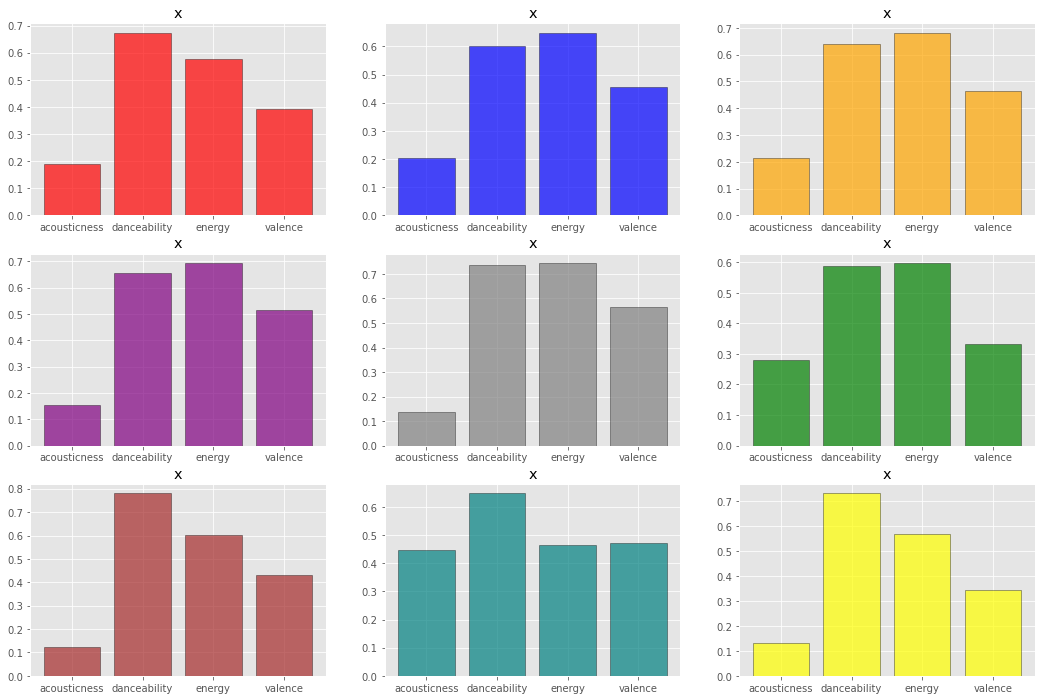

In [20]:
bars = list(top_s.columns)[1:5]

colors = ['red','blue','orange','purple','gray','green','brown','teal','yellow']
fig, ax = plt.subplots(3,3,figsize=(18,12))
for idx, axs in enumerate(ax.flatten()):
    heights = np.array(top_s.iloc[idx,1:5])
    axs.bar(bars,heights,color=colors[idx],edgecolor="black",alpha=.7)
    axs.set_title(top_s.iloc[idx,0])

In [21]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    ## why jitter? especially for bootstraping later
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([0, 1])
    ax.tick_params(axis='both', which='major', labelsize=15)

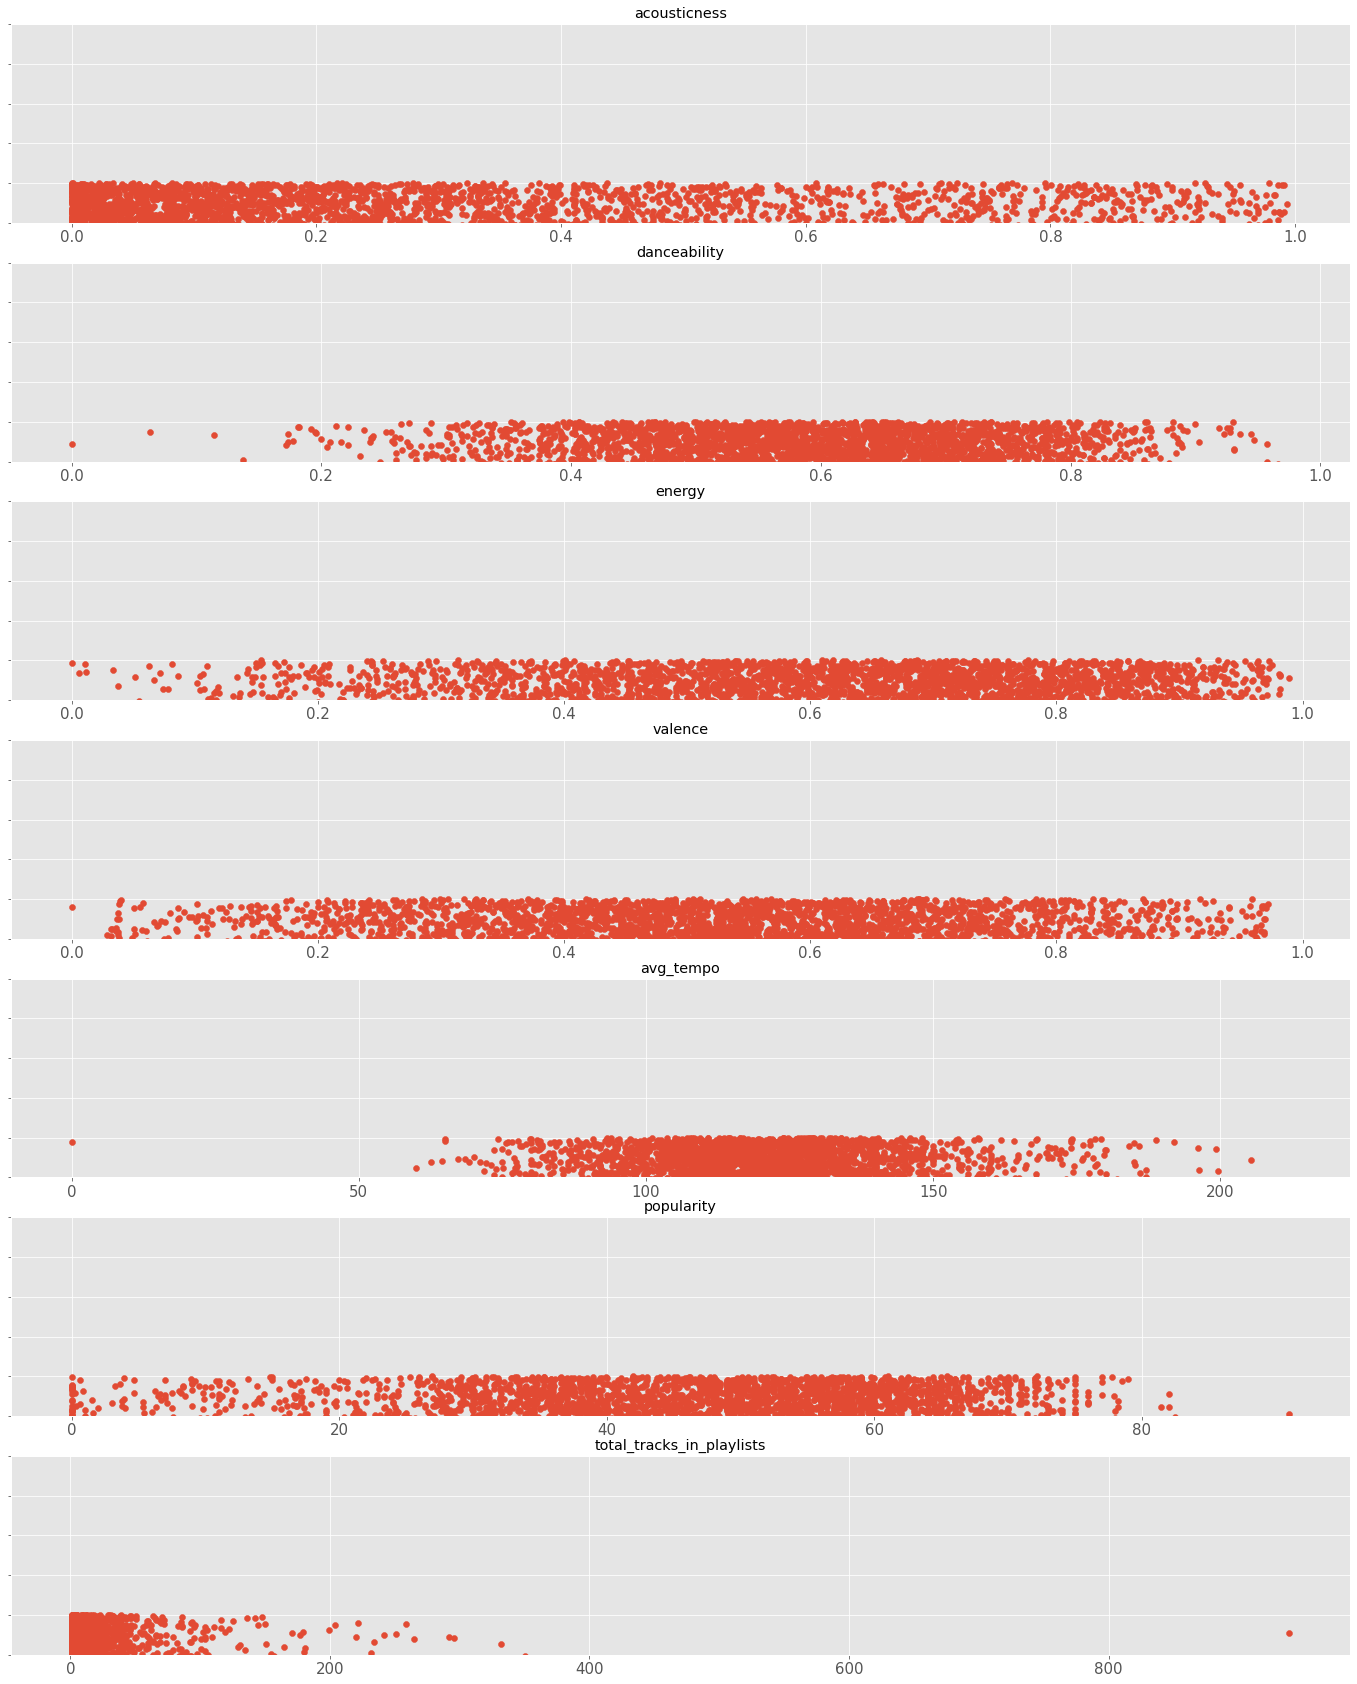

In [22]:
labels = list(top_s.columns)[1:]
fig, ax = plt.subplots(7,1, figsize=(24, 30))
for idx, axs in enumerate(ax.flatten()):
    feature = np.array(top_s.iloc[:,idx+1])
    one_dim_scatterplot(feature, axs)
    axs.set_title(labels[idx])


In [23]:
df_feature_join1 = df_feature_join.withColumn("popularity",F.col("popularity").cast("FloatType"))
df_feature_join1.printSchema()
df_feature_join1.createOrReplaceTempView("feature_join")

ParseException: 
DataType floattype is not supported.(line 1, pos 0)

== SQL ==
FloatType
^^^


In [ ]:
select = spark.sql("""
                    SELECT artist_name
                    ,popularity
                    FROM feature_join
                    WHERE popularity < 0.0000000001
                    GROUP BY artist_name
                    """)
select.show